In [1]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-uyyzrq2x
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-uyyzrq2x
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6860 sha256=5e63d43c026e5d9307746be31f8b86f73aef4724e361eb9adaf5eeb793b5edc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-xulrhbhh/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4

In [3]:
import pandas as pd
from collections import Counter
import re
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
# from datasets import load_metric
import datasets
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from datasets import Dataset, DatasetDict
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import random
np.object = object
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding,BertModel,AutoTokenizer,AutoConfig,RobertaModel
from collections import defaultdict
import torch
import warnings
warnings.filterwarnings('ignore')
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW
from sklearn.model_selection import KFold
from torch.cuda import amp

import gc
gc.enable()

In [4]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [5]:
df = pd.read_csv("/kaggle/input/bengali-pharmaceutical-reviews/LargePharmaVal.csv")

In [6]:
with pd.option_context('display.max_colwidth',0):
    display(df.sample(n=10))

,Reviews,category,Label,Length,Word Count
4144,নকল প্রোডাক্ট। কেউ কিনে প্রতারিত হবেন না। যারা আসল কোরাল ব্যবহার করছে সহজেই ধরতে পারবে এটা যে নকল দুই নাম্বার মাল।,adult_items,1,114,21
2013,এই ক্রিম নিয়ে একদম হতাশ। খুব পাতলা মানের অর্ডার করার 2 দিন পরেও কোনো আপডেট নাই ☹️☹️ বিশ্বাস করে কিনে ভুল করেছি,womens_item,1,111,22
8910,স্কিন টোন উজ্জ্বল হয়েছে! আলহামদুলিল্লাহ খুব ভালো একটা জিনিস 🥰 💯 ১০% ডিসকাউন্ট পেয়েছি। সবাই নিঃসন্দেহে কিনতে পারেন 💯,womens_item,5,117,19
5351,এই শ্যাম্পু আমার জীবনের সবচেয়ে খারাপ কেনাকাটা। ছবির সাথে মিল নাই দাম বেশি কিন্তু মান খারাপ এভাবে প্রতারণা করা ঠিক না,womens_item,1,117,21
6147,হায় হায় 😡😡 এই ওষুধ! ব্যবহার করা যায় না। অর্ডার করার 5 দিন পরেও কোনো আপডেট নাই,medicines,1,80,17
5708,আলহামদুলিল্লাহ ভালো টাইম মত ভেলিভারি পেয়েছি আপনারা চাইলে নিতে পারেন । ভালোই আছে। খুব বেশি না।,womens_item,4,94,16
5014,"ডেলিভারি ম্যান ভদ্র ছিল। ফেসওয়াশ আলহামদুলিল্লাহ ঠিকঠাক পেয়েছি, তবে কিছু মাইনর ইস্যু আছে",womens_item,4,89,13
5450,জীবনে প্রথমবার এতো খারাপ সাপ্লিমেন্ট দেখলাম। ব্র্যান্ড লোগো ভুয়া 😤😤 এভাবে ব্যবসা করা উচিত না,body_fitness,1,93,15
3912,আগে একটা অর্ডার করেছিলাম। ব্যবহার করে ভালো লাগলো। এখন আরও ২ টা নিলাম এবং খুব দ্রুত হাতে পেয়ে গেলাম। ধন্যবাদ দারাজ এবং সাত রঙ।,womens_item,5,125,24
9055,একটি থার্মোমিটারে ৯৬.৫ আরেকটিতে ৯৬.২ ফারেনহাইট দেখায় এই আর কি। অনলাইনের প্রোডাক্ট কম বেশি হবে এটা মেনে নিয়েই অর্ডার করেছিলাম। \nদাম একটু কম করতে পারলে খুশি হতে পারতাম। কারণ ডেলিভারি পৌঁছাতে পৌঁছাতে ১০ দিনের মতো লেগেছে।,medical_kits,4,218,36


In [7]:
df.shape

(9515, 5)

In [8]:
df.shape[0]*0.7

6660.5

In [9]:
df["Label"].value_counts()

Label
5    2238
1    2199
4    1989
2    1563
3    1526
Name: count, dtype: int64

In [10]:
df["Label"] = df["Label"] - 1
df["Label"].value_counts()

Label
4    2238
0    2199
3    1989
1    1563
2    1526
Name: count, dtype: int64

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(df))
    ax = sns.countplot(x=col,  data=df, order = df[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

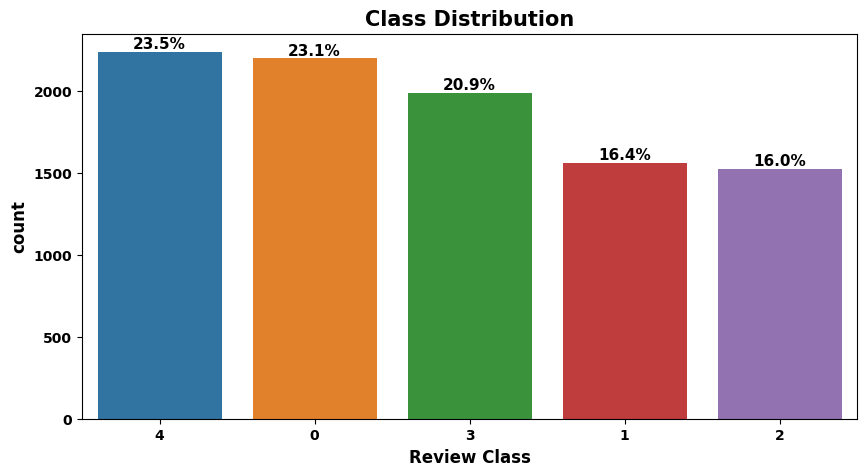

In [12]:
countplot(10,5,'Label',15,0,'Review Class','Class Distribution')

In [13]:
from sklearn.model_selection import train_test_split

# Step 1: Split the data into train and temp (test + validation) sets
X_train, X_test1, y_train, y_test1 = train_test_split(df['Reviews'], df['Label'], test_size=0.3, random_state=42, stratify=df['Label'])

# Step 2: Split the temp set into validation and test sets (10% validation, 20% test)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=2/3, random_state=42, stratify=y_test1)

In [14]:
X_train.shape

(6660,)

In [15]:
train_df = pd.DataFrame()
train_df['text'] = X_train.values
train_df['label'] = y_train.values


In [16]:
val_df = pd.DataFrame()
val_df['text'] = X_val.values
val_df['label'] = y_val.values

In [17]:
test_df = pd.DataFrame()
test_df['text'] = X_test.values
test_df['label'] = y_test.values

In [18]:
train_df.shape

(6660, 2)

In [19]:
train_df.head()

,text,label
0,১০০% অরিজিনাল প্রোডাক্ট! খুব উন্নত মানের প্রোড...,4
1,আলহামদুলিল্লাহ অনেক অনেক ভালো লেগেছে 😍। সুন্দর...,4
2,প্রথম প্রথম ব্যবহার করে খুব ভালো ফল পেয়েছিলাম ...,2
3,অসংখ্য ধন্যবাদ সেলারকে। তিনি কারেন্ট ডেটের এবং...,4
4,৫০ টা মাস্কের অনেক গুলায় নাকে ফিট করার স্টিল ট...,2


In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1904 non-null   object
 1   label   1904 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 29.9+ KB


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train_df))
    ax = sns.countplot(x=col,  data=train_df, order = train_df[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

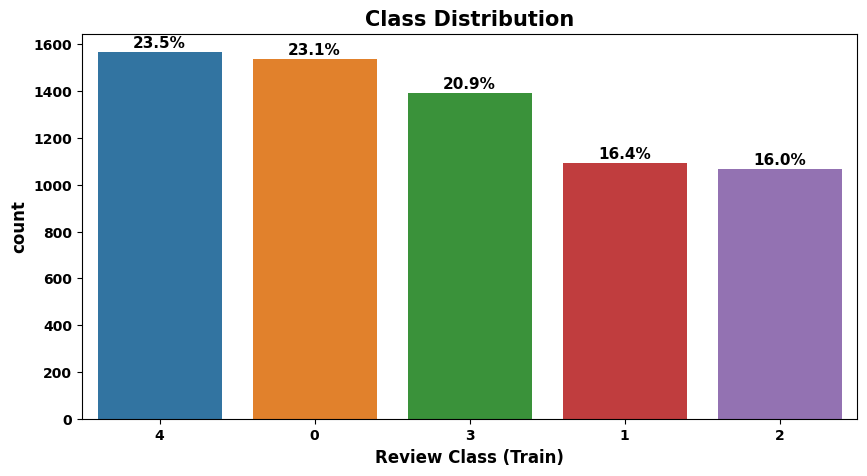

In [22]:
countplot(10,5,'label',15,0,'Review Class (Train)','Class Distribution')

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(val_df))
    ax = sns.countplot(x=col,  data=val_df, order = val_df[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

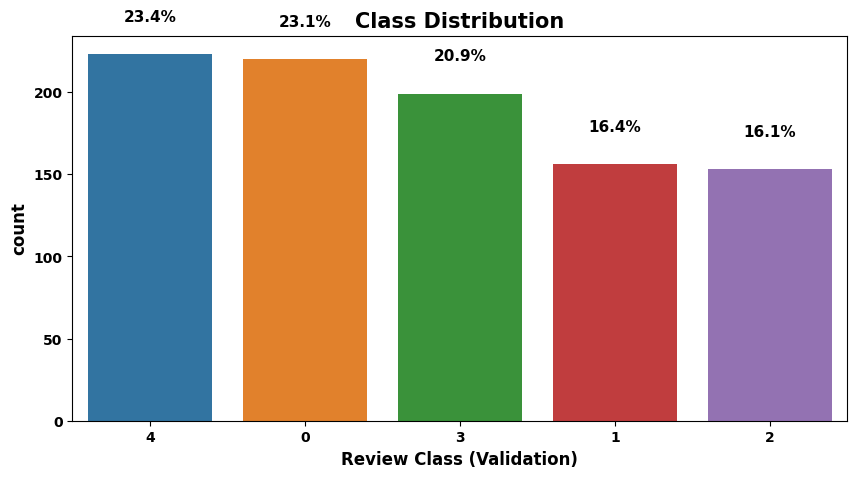

In [24]:
countplot(10,5,'label',15,0,'Review Class (Validation)','Class Distribution')

In [25]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [26]:
class Config:
    num_classes = 5
    path =  "csebuetnlp/banglabert"
    num_epochs = 10
    batch_size = 16
    SEED = 42
    learning_rate = 2e-5
    device = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()

In [27]:
tokenizer = AutoTokenizer.from_pretrained(config.path)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

<Axes: ylabel='Count'>

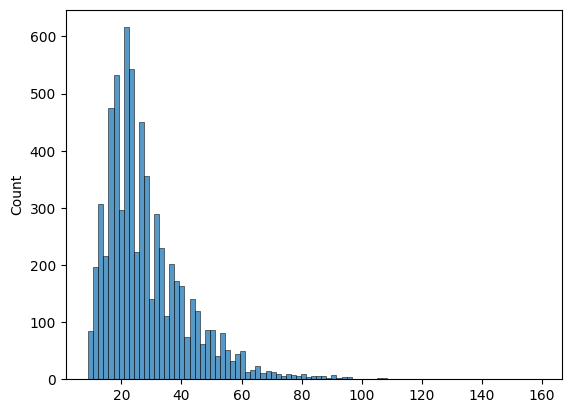

In [28]:
token_counts = []
for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

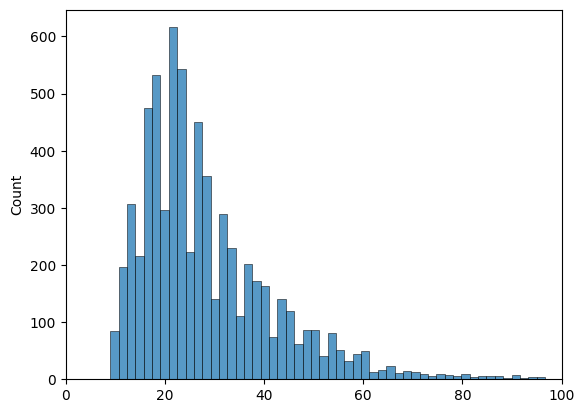

In [29]:
sns.histplot(token_counts)
plt.xlim([0, 100]);

<Axes: ylabel='Count'>

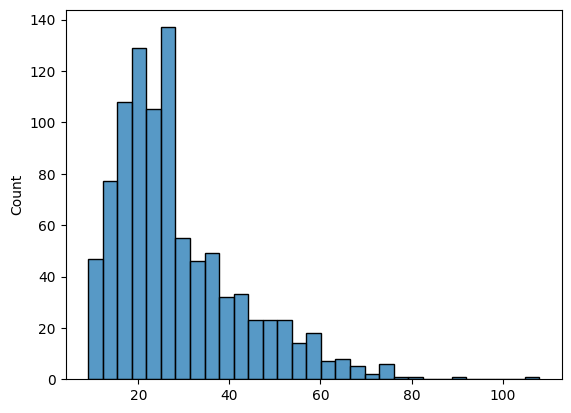

In [30]:
token_counts = []
for _, row in val_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

In [31]:
max(token_counts)

108

<Axes: ylabel='Count'>

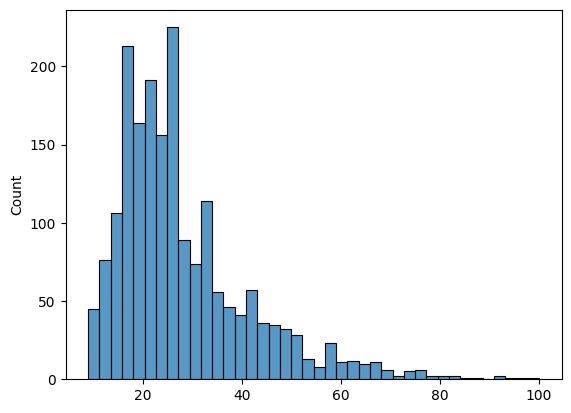

In [32]:
token_counts = []
for _, row in test_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

In [33]:
max(token_counts)

100

In [34]:
max_token_length = 120
def tokenize_function(example):
    return tokenizer(example["text"], padding = True, truncation=True, max_length=max_token_length)

# mapping dataset (actually texts) into tokenized values of pretrained model (provided in path)
tokenized_train_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_val_datasets = val_dataset.map(tokenize_function, batched=True)
tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6660 [00:00<?, ? examples/s]

Map:   0%|          | 0/951 [00:00<?, ? examples/s]

Map:   0%|          | 0/1904 [00:00<?, ? examples/s]

In [35]:
tokenized_train_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6660
})

In [36]:
tokenized_val_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 951
})

In [37]:
tokenized_test_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1904
})

In [38]:
tokenized_train_datasets = tokenized_train_datasets.remove_columns(['text', 'token_type_ids'])
tokenized_val_datasets = tokenized_val_datasets.remove_columns(['text', 'token_type_ids'])
tokenized_test_datasets = tokenized_test_datasets.remove_columns(['text', 'token_type_ids'])
tokenized_train_datasets.set_format("torch")
tokenized_val_datasets.set_format("torch")
tokenized_test_datasets.set_format("torch")

In [39]:
tokenized_test_datasets.column_names

['label', 'input_ids', 'attention_mask']

In [40]:
# class ClassifierModel(nn.Module):

#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.bert = BertModel.from_pretrained(config.path)
#         self.drop = nn.Dropout(p=0.45)
#         self.out = nn.Linear(768, config.num_classes)

#     def forward(self, input_ids, attention_mask):
#         output = self.bert(
#             input_ids = input_ids,
#             attention_mask = attention_mask
#         )

#         x = self.drop(output[1])

#         return self.out(x)

# '''XLM-R Model'''
# from transformers import XLNetModel, XLNetTokenizer

# class ClassifierModel(nn.Module):

#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.xlnet = XLNetModel.from_pretrained(config.path)
#         self.drop = nn.Dropout(p=0.30)
#         self.out = nn.Linear(768, config.num_classes)  

#     def forward(self, input_ids, attention_mask):
#         # XLNet returns two outputs: the last hidden state and the pooled output (similar to BERT)
#         output = self.xlnet(
#             input_ids = input_ids,
#             attention_mask = attention_mask
#         )

#         # Take the first token's representation
#         cls_output = output.last_hidden_state[:, 0, :]  
#         x = self.drop(cls_output)

#         return self.out(x)


# '''ALBert Model'''
# from transformers import AlbertModel


# class ClassifierModel(nn.Module):

#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.albert = AlbertModel.from_pretrained(config.path)
#         self.drop = nn.Dropout(p=0.45)
#         self.out = nn.Linear(768, config.num_classes) 

#     def forward(self, input_ids, attention_mask):
#         output = self.albert(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )

#         pooled_output = output[1]  
#         x = self.drop(pooled_output)

#         return self.out(x)


# '''Indic-BERT'''

# from transformers import AutoModel

# class ClassifierModel(nn.Module):
#     def __init__(self, config):
#         super(ClassifierModel, self).__init__()
#         self.bert = AutoModel.from_pretrained(config.path)  # Changed to AutoModel
#         self.dropout = nn.Dropout(p=0.3)
#         self.fc = nn.Linear(768, config.num_classes)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )

#         pooled_output = outputs.pooler_output  # Using pooler_output safely
#         x = self.dropout(pooled_output)

#         return self.fc(x)


'''Bangla-BERT'''
class ClassifierModel(nn.Module):
    def __init__(self, config):  # Add config parameter
        super(ClassifierModel, self).__init__()
        self.bert = BertModel.from_pretrained(config.path)
        self.drop = nn.Dropout(p=0.45)
        self.out = nn.Linear(768, config.num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        x = self.drop(output[1])
        return self.out(x)

In [41]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score


class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        pred = pred.cpu().numpy()
        y_pred = np.argmax(pred, axis = -1)
        f1 = f1_score(y_true, y_pred, average='macro')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        DEVICE = config.device
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(DEVICE)
            attention_mask = data["attention_mask"].to(DEVICE)            
            target = data["labels"].to(DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        DEVICE = config.device
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(DEVICE)
                attention_mask = data["attention_mask"].to(DEVICE)            
                target = data["labels"].to(DEVICE)
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [42]:
from transformers import get_scheduler

def run_training(save_model = False):

    train_loader = DataLoader(tokenized_train_datasets, batch_size = config.batch_size,
                              collate_fn=data_collator, shuffle =True, num_workers=2)    
    val_loader = DataLoader(tokenized_val_datasets, batch_size = config.batch_size,
                            drop_last=False,collate_fn=data_collator, shuffle=False, num_workers=2)   
    set_random_seed(config.SEED)
    model = ClassifierModel(config)
    model.to(config.device)
    
#     optimizer = create_optimizer(model)  
    optimizer = torch.optim.AdamW(model.parameters(), lr = config.learning_rate, weight_decay=0.01)
    num_training_steps = config.num_epochs * len(train_loader)
    
    scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
    )
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 5
    early_stopping_counter = 0
    best_score = 0.0
    for epoch in range(config.num_epochs):
        train_loss = eng.train(train_loader,scaler,num_training_steps)
        val_score,val_loss = eng.evaluate(val_loader)
        
        print(f" Epoch: {epoch + 1} | Training_loss: {round(train_loss,5)} | Val_loss: {round(val_loss,5)} | Val_Score: {round(val_score,5)}")
        
        if val_score > best_score:
            best_score = val_score
            
            if save_model:
                torch.save(model.state_dict(),f"banglabert_model.bin")
        else:
            early_stopping_counter +=1
            
        if early_stopping_counter > early_stopping_iter:
            break
            
    del model
    gc.collect()
            
    return best_score

In [43]:
score = run_training(save_model = True)
print(f"Best Score: {score}")

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.lay

  0%|          | 0/4170 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

 Epoch: 1 | Training_loss: 1.00506 | Val_loss: 0.52174 | Val_Score: 0.75085


  0%|          | 0/4170 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8f3afac0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8f3afac0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/60 [00:00<?, ?it/s]

 Epoch: 2 | Training_loss: 0.43978 | Val_loss: 0.41185 | Val_Score: 0.81277


  0%|          | 0/4170 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

 Epoch: 3 | Training_loss: 0.31285 | Val_loss: 0.36828 | Val_Score: 0.82695


  0%|          | 0/4170 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

 Epoch: 4 | Training_loss: 0.24058 | Val_loss: 0.36771 | Val_Score: 0.8447


  0%|          | 0/4170 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

 Epoch: 5 | Training_loss: 0.20133 | Val_loss: 0.36943 | Val_Score: 0.84817


  0%|          | 0/4170 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

 Epoch: 6 | Training_loss: 0.14561 | Val_loss: 0.39609 | Val_Score: 0.85082


  0%|          | 0/4170 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

 Epoch: 7 | Training_loss: 0.10616 | Val_loss: 0.44287 | Val_Score: 0.84406


  0%|          | 0/4170 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8f3afac0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8f3afac0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/60 [00:00<?, ?it/s]

 Epoch: 8 | Training_loss: 0.07688 | Val_loss: 0.44523 | Val_Score: 0.85191


  0%|          | 0/4170 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

 Epoch: 9 | Training_loss: 0.06137 | Val_loss: 0.40712 | Val_Score: 0.844


  0%|          | 0/4170 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

 Epoch: 10 | Training_loss: 0.04455 | Val_loss: 0.40775 | Val_Score: 0.85526
Best Score: 0.8552604617604617


In [44]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    tokenized_test_datasets, batch_size=32, collate_fn=data_collator
)

In [45]:
device = config.device

In [46]:
model = ClassifierModel(config)

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermedi

In [47]:
model_path = f"/kaggle/working/banglabert_model.bin"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [48]:
model.to(device)

ClassifierModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [49]:
model.eval()
prediction = []
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])
        logits = outputs
        pred = torch.argmax(logits, dim=-1)
        prediction.extend(pred.cpu().numpy().tolist())

In [50]:
y_true = test_df.label.values
y_pred = prediction

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_true, y_pred))

[[417  15   8   0   0]
 [ 36 251  22   3   1]
 [  5  29 240  28   3]
 [  4   6  28 348  12]
 [  1   1   1  10 435]]


In [52]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

# Print the classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Calculate individual metrics for weighted and macro averages
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_f1 = f1_score(y_true, y_pred, average='macro')

weighted_precision = precision_score(y_true, y_pred, average='weighted')
macro_precision = precision_score(y_true, y_pred, average='macro')

weighted_recall = recall_score(y_true, y_pred, average='weighted')
macro_recall = recall_score(y_true, y_pred, average='macro')

accuracy = accuracy_score(y_true, y_pred)

print("Model: BanglaBERT")

# Print metrics
print("Weighted F1 Score:", weighted_f1)
print("Macro F1 Score:", macro_f1)
print("Weighted Precision:", weighted_precision)
print("Macro Precision:", macro_precision)
print("Weighted Recall:", weighted_recall)
print("Macro Recall:", macro_recall)
print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       440
           1       0.83      0.80      0.82       313
           2       0.80      0.79      0.79       305
           3       0.89      0.87      0.88       398
           4       0.96      0.97      0.97       448

    accuracy                           0.89      1904
   macro avg       0.88      0.88      0.88      1904
weighted avg       0.89      0.89      0.89      1904

Confusion Matrix:
 [[417  15   8   0   0]
 [ 36 251  22   3   1]
 [  5  29 240  28   3]
 [  4   6  28 348  12]
 [  1   1   1  10 435]]
Model: BanglaBERT
Weighted F1 Score: 0.887489669708187
Macro F1 Score: 0.8773326307864956
Weighted Precision: 0.8872906401506561
Macro Precision: 0.8787148370551805
Weighted Recall: 0.8881302521008403
Macro Recall: 0.8763766907379772
Accuracy: 0.8881302521008403


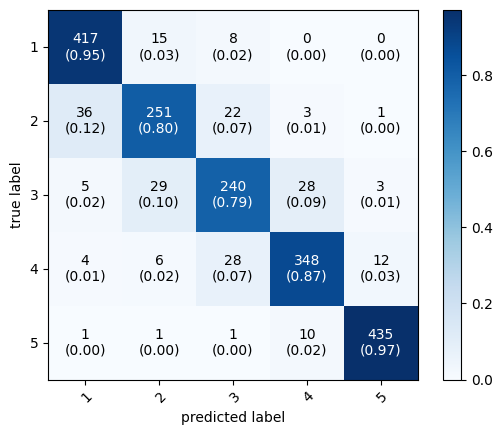

In [53]:
import torch
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
y_pred = torch.tensor(y_pred)
y_true = torch.tensor(y_true)

cmat = ConfusionMatrix(task="multiclass", num_classes=5)
confusion_matrix = cmat(y_pred, y_true)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.cpu().numpy(),
                                class_names=[1,2,3,4,5],
                                show_normed=True,
                                colorbar=True)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# Show the plot
plt.show()